# Data preprocessing and CNN  definition to classify a special click noise 

This notebook illustrates the detailed creation of the CNN implementation for our paper.

Notes:
- All '#free memory space' cells can be ignored if you have 32 gb of RAM or more
- We ran all experiments on a server with 128 gb of RAM and Nvidia Tesla P100 GPU

## Introduction 

Fo the implementation of our CNN model we adopted the baseline CNN of the “IEEE AASP Challenge on Detection and Classification of Acoustic Scenes and Events” (DCASE) 2019 challenge. Since 2013, the DCASE competition aims to continuously support the development of computational scene and event analysis methods by comparing different approaches using common publicly available benchmarks. It is a well-known challenge in the sound classification research community presenting state-of-the-art architectures. Therefore, we adopt the current DCASE-19 baseline model, which proved to be successful in the 2016 DCASE challenge, to tackle the classification problem at hand. This CNN comprises two convolutional layers and one dense layer, followed by a softmax classification layer. For regularization, we included batch normalization after each convolutional layer and dropout after all layers. In addition we adopted the model to binary classification.

In [59]:
import numpy as np
import random
from scipy.signal import spectrogram, stft
import matplotlib.pyplot as plt

import pandas as pd
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, matthews_corrcoef

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import GaussianNoise, ReLU, LeakyReLU, MaxPooling2D,Conv2D, GRU, GlobalAveragePooling1D, MaxPooling1D, LSTM, Dense, Conv1D, AveragePooling1D, Input, Dropout, BatchNormalization, Activation, Flatten, BatchNormalization, concatenate, Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l2, l1, l1_l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD

import metrics

In [2]:
SEED = 42
FOLDS = 5
PATIENCE = 100
BATCH_SIZE = 32
EPOCHS = 100
VAL_SPLIT = 0.1
TEST_SPLIT = 0.2
CHECKPOINT = "model_cp"
METRICS = ['accuracy', metrics.recall, metrics.precision, metrics.f1, metrics.mcor]
LOG_DIR = "ICIS_logs/strat_test"

In [3]:
tensorboard = TensorBoard(log_dir=LOG_DIR,
                          histogram_freq=0,
                          batch_size=BATCH_SIZE,
                          write_graph=False,
                          write_grads=False,
                          write_images=False,
                          embeddings_freq=0,
                          embeddings_layer_names=None,
                          embeddings_metadata=None)

#ES = EarlyStopping(monitor='val_loss', 
#                   min_delta=0,
#                   patience=PATIENCE, 
#                   verbose=0, 
#                   mode='auto', 
#                   baseline=None, 
#                   restore_best_weights=False)

#cp = ModelCheckpoint(filepath=CHECKPOINT,
#                     monitor='val_loss',
#                     verbose=0,
#                     save_best_only=True,
#                     save_weights_only=False,
#                     mode='auto',
#                     period=1)

/Users/stellaris/anaconda3/envs/Sc_interpreter/lib/python3.6/site-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


## Loading data

In [4]:
x_niko = np.load("data/raw/x_niko.npy")
x_adrian = np.load("data/raw/x_adrian.npy")
x_toni = np.load("data/raw/x_toni.npy")
x_adrian2 = np.load("data/raw/x_adrian2.npy")
x_adrian3 = np.load("data/raw/x_adrian3.npy")
x_raw = np.concatenate((x_adrian, x_niko,x_toni,x_adrian2,x_adrian3), axis=0)

In [5]:
#free memory space
del x_niko
del x_adrian
del x_toni
del x_adrian2
del x_adrian3

In [6]:
y_niko = np.load("data/raw/y_niko.npy")
y_adrian = np.load("data/raw/y_adrian.npy")
y_toni = np.load("data/raw/y_toni.npy")
y_adrian2 = np.load("data/raw/y_adrian2.npy")
y_adrian3 = np.load("data/raw/y_adrian3.npy")
y_raw = np.concatenate((y_adrian, y_niko,y_toni,np.squeeze(y_adrian2),y_adrian3))

In [7]:
#free memory space
del y_niko
del y_adrian
del y_toni
del y_adrian2
del y_adrian3

## Data preparation

In [8]:
neg_example = random.sample(list(np.where(y_raw==0)[0]),1)[0]
pos_example = random.sample(list(np.where(y_raw==1)[0]),1)[0]

### Plot example

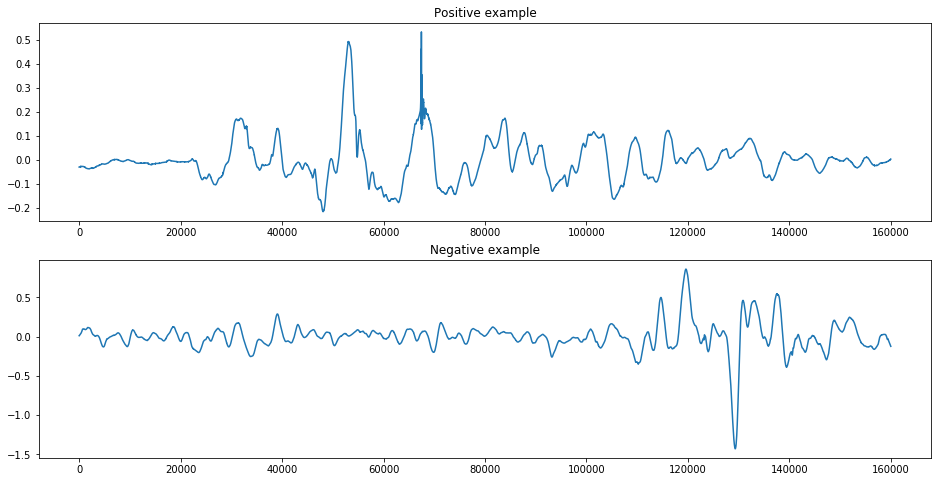

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(16,8))
axes[0].plot(x_raw[pos_example])
axes[0].set_title('Positive example')
axes[1].plot(x_raw[neg_example])
axes[1].set_title('Negative example')  
_ = fig

### Fourier Transformation

Network architectures for sound classification are designed to classify an acoustic signal based on its frequency spectrum. To obtain this, we decompose each recorded five-second time window into its individual frequencies utilizing the short-time Fourier transformation. This transformation splits a function of time (the sensor readings) into its frequencies. Performing the Fourier Transformation on our one-dimensional raw sensor data returns a two-dimensional spectrogram.

In [11]:
four_lst = [stft(x,fs=fs,nfft=nfft) for x in list(x_raw)]
x_four = np.abs(np.asarray([four_lst[i][2] for i in range(len(four_lst))]))

### Plot fourier transformed sample

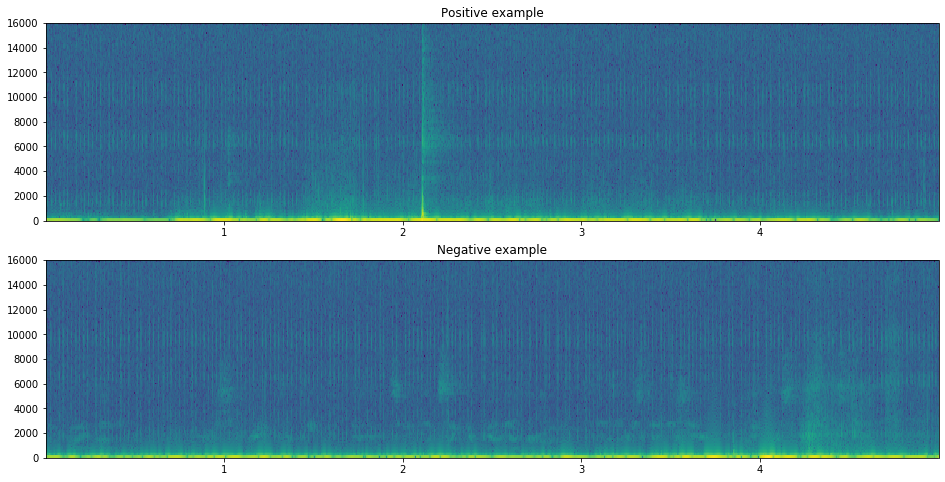

In [10]:
nfft=256
fs=32000

# spectrum : 2-D array Columns are the periodograms of successive segments.
# freqs : 1-D array  The frequencies corresponding to the rows in *spectrum*.
# t : 1-D array  The times corresponding to midpoints of segments (i.e., the columnsin *spectrum*).
# im : instance of class :class:`~matplotlib.image.AxesImage`  The image created by imshow containing the spectrogram

fig, axes = plt.subplots(2, 1,figsize=(16,8))
axes[0].specgram(x_raw[pos_example], Fs=fs, NFFT=nfft)
axes[0].set_title('Positive example')
axes[1].specgram(x_raw[neg_example], Fs=fs, NFFT=nfft) #scale='linear'
axes[1].set_title('Negative example')
_ = fig

In [12]:
#free memory space
del x_raw

In [19]:
x_four = np.load("data/fourier/x_four.npz")
#y_raw = np.load("data/fourier/y.npz")

### Log scaling

Neural networks converge faster and therefore perform better if the input variables follow a standard normal distribution. Hence, we perform a log transformation on the spectrogram and subsequently standardize the input variables.

In [14]:
x_log = 10. * np.log10(x_four+np.finfo(float).eps) # from plt.spectrogram

### Check Outliers

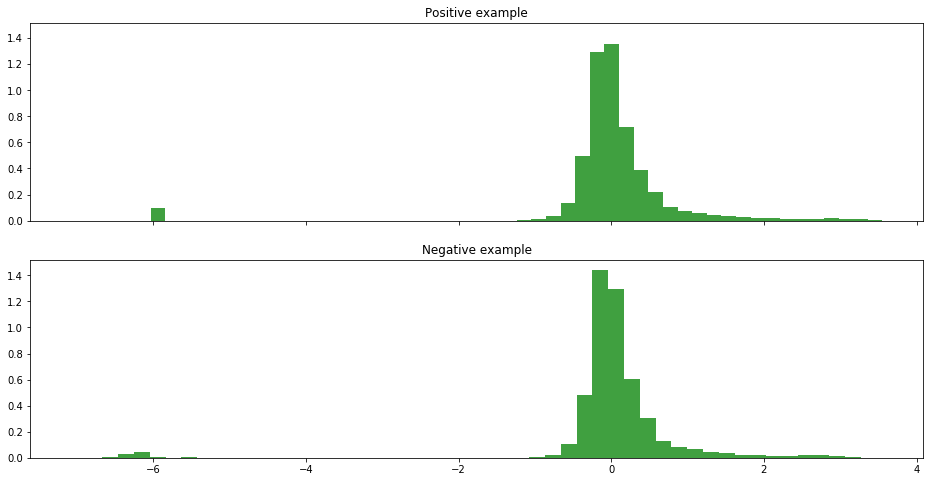

In [20]:
# Problemmatic value at 460
x1 = np.log10(x_four[460]+np.finfo(float).eps).flatten()
arr = x_four[460]
arr[arr == 0] = np.finfo(float).eps
x2 = np.log10(arr.flatten())

sd1 = np.std(x1)
sd2 = np.std(x2)

m1 = x1.mean()
m2 = x2.mean()

fig, axes = plt.subplots(2, 1,figsize=(16,8), sharex=True, sharey=True)
axes[0].hist((x1-m1)/sd1, 50, density=True, facecolor='g', alpha=0.75)
axes[0].set_title('Positive example')
axes[1].hist((x2-m2)/sd2, 50, density=True, facecolor='g', alpha=0.75)
axes[1].set_title('Negative example')
_=fig

In [25]:
#free memory space
del four_lst
del x_four

### Reshape data

In [26]:
x_shape = x_log.reshape((x_log.shape[0],x_log.shape[1],x_log.shape[2], 1))

In [27]:
#free memory space
del x_log

In [28]:
x_shape = x_shape[:,:,:-1,:]

### Train-Test Split

In [ ]:
#x_shape = np.load("data/x_shape")

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_shape, 
                                                    y_raw, 
                                                    test_size=TEST_SPLIT, 
                                                    stratify=y_raw,
                                                    random_state=SEED)

### Train-Val Split

In [32]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train, y_train, 
                                                    # strafify=y_train, 
                                                    test_size=VAL_SPLIT, random_state=SEED)

### Normalize training data

From https://www.researchgate.net/post/What_is_the_correct_way_of_normalizing_an_audio_signal:
- It really depends on what the objective of the normalisation is. Unless you have some way of explicitly calibrating the sound pressure level to which a quantisation level corresponds, you probably don't want to overcomplicate it. I would also suggest that normalising it to the peak absolute value is not a very useful approach under any circumstances - firstly, you probably have a small DC offset, so you want to first subtract the mean, and secondly, you may have some impulse noise present - which would give you a rather misleading result as you may end up with a very much lower-amplitude signal than you expect.
- You could normalise signal power by computing the average power of the signal and then scaling the signal such that the average power is unity. However, if your signal is music or speech, this will tend to be skewed by quiet parts of the signal - it really only makes sense if the signal has a roughly constant power envelope. There is no 'correct' way to do this which is suitable for all cases.

In [33]:
# for internal model split
norm_mean = x_train.mean()
norm_std = x_train.std()
norm_max = x_train.max()

x_train = (x_train-norm_mean)/norm_std
x_test = (x_test-norm_mean)/norm_std

In [34]:
# For manual model split
norm_mean2 = x_train2.mean()
norm_std2 = x_train2.std()
norm_max2 = x_train2.max()

x_train2 = (x_train2-norm_mean2)/norm_std2
x_val2 = (x_val2-norm_mean2)/norm_std2

### Plot final data distribution

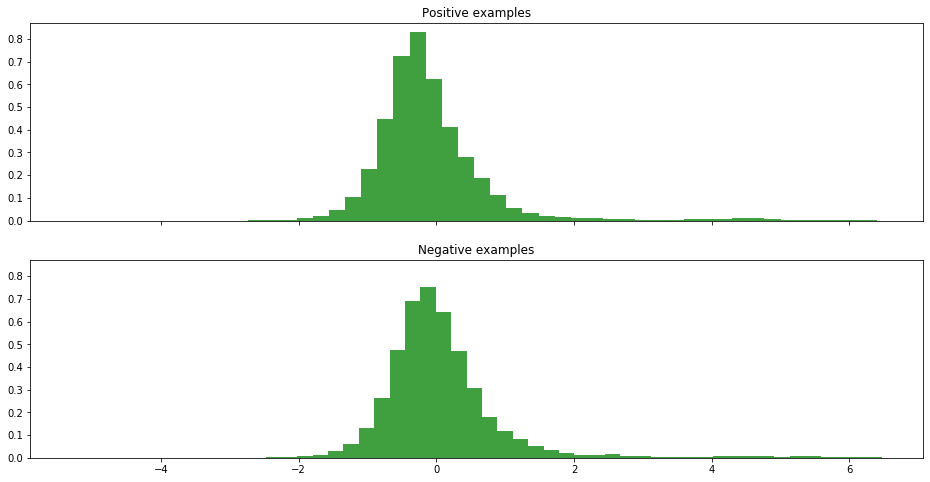

In [39]:
fig, axes = plt.subplots(2, 1,figsize=(16,8), sharex=True, sharey=True)
axes[0].hist(x_train[pos_example,:,:,-1].flatten(), 50, density=True, facecolor='g', alpha=0.75)
axes[0].set_title('Positive examples')
axes[1].hist(x_train[neg_example,:,:,-1].flatten(), 50, density=True, facecolor='g', alpha=0.75)
axes[1].set_title('Negative examples')
_=fig

## CNN modelling

The CNN comprises two convolutional layers and one dense layer, followed by a binary classification layer. For regularization, we included batch normalization after each convolutional layer and dropout after all layers. We minimize the binary cross-entropy loss by means of the Adam optimizer.

### CNN structure

In [50]:
#gebaut nach https://github.com/DCASE-REPO/dcase2018_baseline/blob/master/task1/task1a.yaml 
def CNN_model():
    model = Sequential()
    
    model.add(GaussianNoise( 0.01, input_shape=x_train.shape[-3:]))
    model.add(Conv2D(32, (7, 7), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(5, 5), padding = 'same'))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (7, 7), padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(4, 100), padding = 'same'))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
                  optimizer="adam",                       
                  metrics=METRICS)
    return model

In [51]:
CNN = CNN_model()

### CNN training

In [ ]:
CNN_history = CNN.fit(x_train2, y_train2, 
               batch_size = BATCH_SIZE, 
               epochs=EPOCHS, 
               validation_data=(x_val,y_val),
               callbacks=[ES, tensorboard]
               )

### Load trained CNN weigths

In [52]:
#CNN.save("models/CNN.h5")
CNN.load_weights("models/CNN.h5")

### Predict with CNN

In [53]:
y_pred = CNN.predict_classes(x_test, verbose=1, batch_size=BATCH_SIZE) 
print(balanced_accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

875/875 [==============================] - 35s 40ms/step
0.9925654299683635
[[569   1]
 [  4 301]]


## Show results

In [72]:
res = [type(CNN).__name__,
       balanced_accuracy_score(y_test, y_pred)*100,
       precision_score(y_test, y_pred)*100,
       recall_score(y_test, y_pred)*100,
       f1_score(y_test, y_pred)*100,
       matthews_corrcoef(y_test, y_pred)*100]

In [73]:
df = pd.DataFrame(res[1:6], index = ["Balanced ", "Precision", "Recall", "F1", "MCC"], columns = ["CNN"]).round(decimals=2)
df

,CNN
Balanced,99.26
Precision,99.67
Recall,98.69
F1,99.18
MCC,98.74
